In [ ]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from tabulate import tabulate
BASE_PATH ='/home/amirh/code/can_explanations_explain_lam/tabular/regression/data'
import joblib
import matplotlib.pyplot as plt

In [ ]:
from sklearn.base import TransformerMixin
import scipy
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        if type(X) == scipy.sparse.csr.csr_matrix:    
            return X.todense()
        else: 
            return X

In [ ]:
#measures = pickle.load( open( "{}/exp_reg_accuracy_v8.p".format(BASE_PATH), "rb" ) )
measures = pickle.load( open( "{}/exp_reg_accuracy_v17.p".format(BASE_PATH), "rb" ) )
data_info = pickle.load(open("{}/data_info_v1.p".format(BASE_PATH), "rb"))

In [ ]:
#datasets =  ['housing', 'automobile', 'insurance']
#dataset_names =  ['housing', 'automobile', 'insurance']
#datasets = ['wineWhite', 'wineRed', 'puma8fh', 'anacalt',  'kin8nm', 'istanbul', 'bank8fm', 'mg', 'treasury', 'kin8fm',
#               'quakes', 'kin8fh', 'wizmir', 'bank8fh',  'kin8nh', 'puma8fm', 'bank8nm', 'bank8nh', 'deltaA', 'deltaE', 'mortage']
datasets = ['wineWhite', 'wineRed', 'puma8fh', 'anacalt',  'kin8nm', 'istanbul', 'bank8fm', 'treasury', 'kin8fm',
               'quakes', 'kin8fh', 'wizmir', 'bank8fh',  'kin8nh', 'puma8fm', 'bank8nm', 'bank8nh', 'deltaA', 'deltaE', 'mortage']


In [ ]:
dataset_names = []
for d in datasets:
    dataset_names.append(d.title())

In [ ]:
data_feat_len = []

for d in datasets:
    data_feat_len.append(len(data_info[d]['features']))

In [ ]:
models = ['lr']
#preprocessing = ['standard', 'robust', 'minmax']
preprocessing = ['standard']
measure_names = ['spearman_abs', 'cosine', 'norm']
exp_models = ['lime', 'shap', 'lpi']

In [ ]:
from sklearn.metrics import mean_squared_error
model = 'lr'
model_perf = {}
for preproc in ['standard', 'minmax', 'robust']:
    model_perf[preproc] = []
    for data_key in datasets: 
        x_test = np.load('{}/{}/{}/x_test.npy'.format(BASE_PATH, data_key, preproc),  allow_pickle=True)
        y_test = np.load('{}/{}/{}/y_test.npy'.format(BASE_PATH, data_key, preproc),  allow_pickle=True)

        model_object = joblib.load('{}/{}/{}/lr_v2.joblib'.format(BASE_PATH, data_key, preproc, model))

        x_test_transformed = model_object['to_dense'].transform(x_test)
        pred = model_object.predict(x_test_transformed)
        model_perf[preproc].append(mean_squared_error(y_test, pred))

In [ ]:
info = pd.DataFrame([data_feat_len, model_perf['standard']]).T
info.index = dataset_names
info = info.sort_index()

In [ ]:
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
print(tabulate(info.round(2).sort_index(), tablefmt="latex_raw"))

In [ ]:
def get_mean_measure(models, preproc, exp_models = ['lime', 'shap', 'lpi'], measure_name='spearman_abs'):
    mean_measure = pd.DataFrame()

    #for model in models:
    for exp_model in exp_models: 
        _measure = measures[preproc][model][exp_model]
        mean_measure_res = []
        # We exclude MG dataset here
        new_idx = np.setxor1d(np.arange(21), 7)
        
        for j in new_idx:
            avg_measure = np.nanmean(_measure[j][measure_name])
            mean_measure_res.append(avg_measure)
        mean_measure[exp_model] =  mean_measure_res
    mean_measure.index = dataset_names 
        
    mean_measure['# Features'] = data_feat_len
    #print(data_feat_len)
    #mean_measure['# Cat Features'] = data_cat_feat_len
    mean_measure = mean_measure.sort_index().round(3)
    mean_measure['Accuracy'] = model_perf['standard']
    #mean_measure.loc['Average'] = mean_measure.mean()
    #mean_measure.loc['Standard Deviation'] = mean_measure.std()

    return mean_measure

def get_all_rank_preproc(measure_name):
    all_ranks = []
    for preproc in preprocessing:
        get_mean_spearman = get_mean_measure(models, preproc, ['lime', 'shap', 'lpi'], measure_name)
        all_ranks.append(get_mean_spearman.loc['Average'])
    return pd.DataFrame(all_ranks, index=preprocessing)

def get_all_rank_measure(preproc='standard'):
    all_ranks = []
    for measure in measure_names:
        get_mean_spearman = get_mean_measure(models, preproc, measure_name=measure)
        all_ranks.append(get_mean_spearman.loc['Average'])
    return pd.DataFrame(all_ranks, index=measure_names)

In [ ]:
#get_all_rank_measure(preproc='standard').iloc[:, :-2]

In [ ]:
#print(tabulate(get_all_rank_measure(preproc='standard').round(3).iloc[:, :-2], tablefmt="latex_raw"))

In [ ]:
m_spearman = get_mean_measure(models, 'standard', measure_name='spearman_abs')
#m_spearman.sort_values(by=['# Cat Features'], ascending=False)
m_spearman.columns = ['LIME', 'SHAP', 'LPI', '# Features', 'Accuracy']

In [ ]:
m_spearman

In [ ]:
from tabulate import tabulate
print(tabulate(m_spearman.iloc[:, 0:3].round(3), tablefmt="latex_raw"))

In [ ]:
#lreg_spearman = m_spearman.iloc[:, [0, 1, 2, -1, -2]].sort_values(by=['# Cat Features'])
#lreg_spearman.columns = ['LIME', 'SHAP', 'LPI', '# Cat Features', '# Features']
p = sns.pairplot(m_spearman, kind="reg")
p

In [ ]:
from scipy.stats import pearsonr
exp_colors = ['#C4A705', '#E97439', '#65ED99']

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, sharex=True)
sns.set_style("white")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

ax.xaxis.set_tick_params(labelsize=18, bottom=True)
ax.yaxis.set_tick_params(labelsize=18, bottom=True)

#m_spearman_1 = m_spearman[m_spearman.loc[:, '# Cat. Feat'] > 0]

lime_coef =  np.array(pearsonr(m_spearman.loc[:, 'LIME'], m_spearman.loc[:, '# Features'])).round(2)
lime_coef_str = '{}, {}'.format(lime_coef[0], lime_coef[1])

shap_coef =  np.array(pearsonr(m_spearman.loc[:, 'SHAP'], m_spearman.loc[:, '# Features'])).round(2)
shap_coef_str = '{}, {}'.format(shap_coef[0], shap_coef[1])

lpi_coef =  np.array(pearsonr(m_spearman.loc[:, 'LPI'], m_spearman.loc[:, '# Features'])).round(2)
lpi_coef_str = '{}, {}'.format(lpi_coef[0], lpi_coef[1])

sns.regplot(x="# Features", y="LIME", data=m_spearman, 
            ax=ax, label='LIME ({})'.format(lime_coef_str), color=exp_colors[0], ci=None, line_kws={'linestyle':'--'}, robust=True);
#ax.scatter(m_spearman_1.loc[:, '# Cat. Feat'], m_spearman_1.loc[:, 'LIME'], color=exp_colors[0])
#ax.plot(m_spearman_1.loc[:, '# Cat. Feat'], m_spearman_1.loc[:, 'LIME'], color=exp_colors[0], label='LIME ({})'.format(lime_coef_str))

sns.regplot(x="# Features", y="SHAP", data=m_spearman, 
            ax=ax, label='SHAP ({})'.format(shap_coef_str), color=exp_colors[1], ci=None, line_kws={'linestyle':'--'}, robust=True);


sns.regplot(x="# Features", y="LPI", data=m_spearman, 
            ax=ax, label='LPI ({})'.format(lpi_coef_str), color=exp_colors[2], ci=None, line_kws={'linestyle':'--'}, robust=True);
#ax.set(ylabel='Average Explanation Accuracy', xlabel='% Categorical Features')
ax.set(ylabel='Average Explanation Accuracy', xlabel='# Numerical Features')
ax.legend(fontsize=13)
plt.savefig('./num_feat_linear_regression.eps', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, sharex=True)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

ax.xaxis.set_tick_params(labelsize=18, bottom=True)
ax.yaxis.set_tick_params(labelsize=18, bottom=True)


lime_coef =  np.array(pearsonr(m_spearman.loc[:, 'LIME'], m_spearman.loc[:, 'Accuracy'])).round(2)
lime_coef_str = '{}, {}'.format(lime_coef[0], lime_coef[1])

shap_coef =  np.array(pearsonr(m_spearman.loc[:, 'SHAP'], m_spearman.loc[:, 'Accuracy'])).round(2)
shap_coef_str = '{}, {}'.format(shap_coef[0], shap_coef[1])

lpi_coef =  np.array(pearsonr(m_spearman.loc[:, 'LPI'], m_spearman.loc[:, 'Accuracy'])).round(2)
lpi_coef_str = '{}, {}'.format(lpi_coef[0], lpi_coef[1])


sns.regplot(x="Accuracy", y="LIME", data=m_spearman, 
            ax=ax, label='LIME ({})'.format(lime_coef_str),  color=exp_colors[0], ci=None, line_kws={'linestyle':'--'});
sns.regplot(x="Accuracy", y="SHAP", data=m_spearman, ax=ax, 
            label='SHAP ({})'.format(shap_coef_str),  color=exp_colors[1], ci=None, line_kws={'linestyle':'--'});
sns.regplot(x="Accuracy", y="LPI", data=m_spearman, ax=ax, 
            label='LPI ({})'.format(lpi_coef_str),  color=exp_colors[2], ci=None, line_kws={'linestyle':'--'});
ax.set(ylabel='Average Explanation Accuracy', xlabel='Model Test Error')
ax.legend(fontsize=13)
plt.savefig('model_accuracy_linear_regression.eps', bbox_inches='tight')

In [ ]:
preproc = 'standard'
inner_corr = []
for data_key in datasets: 
    x_train = np.load('{}/{}/{}/x_train.npy'.format(BASE_PATH, data_key, preproc),  allow_pickle=True)
    model_object = joblib.load('{}/{}/{}/{}_v2.joblib'.format(BASE_PATH, data_key, preproc, model))
    
    x_train_transformed = model_object['to_dense'].transform(x_train)
    
    corr_matrix = np.corrcoef(x_train_transformed, rowvar=False)
    corr_matrix[np.tril_indices(corr_matrix.shape[0])] = np.nan
    corr_feat_nums = (corr_matrix > 0.7).sum()
    tot_feat = (x_train_transformed.shape[1] * (x_train_transformed.shape[1] - 1))
    
    #inner_corr.append( corr_feat_nums/ tot_feat )
    inner_corr.append( corr_feat_nums)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, sharex=True)
sns.set_style("white")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

ax.xaxis.set_tick_params(labelsize=18, bottom=True)
ax.yaxis.set_tick_params(labelsize=18, bottom=True)

#m_spearman_2 = m_spearman[m_spearman.loc[:, '# Corr. Feat'] > 0]

lime_coef =  np.array(pearsonr(m_spearman.loc[:, 'LIME'], inner_corr)).round(2)
lime_coef_str = '{}, {}'.format(lime_coef[0], lime_coef[1])

shap_coef =  np.array(pearsonr(m_spearman.loc[:, 'SHAP'], inner_corr)).round(2)
shap_coef_str = '{}, {}'.format(shap_coef[0], shap_coef[1])

lpi_coef =  np.array(pearsonr(m_spearman.loc[:, 'LPI'], inner_corr)).round(2)
lpi_coef_str = '{}, {}'.format(lpi_coef[0], lpi_coef[1])

sns.regplot(x=inner_corr, y="LIME", data=m_spearman, 
            ax=ax, label='LIME ({})'.format(lime_coef_str), color=exp_colors[0], ci=None, line_kws={'linestyle':'--'}, robust=True);
sns.regplot(x=inner_corr, y="SHAP", data=m_spearman, 
            ax=ax, label='SHAP ({})'.format(shap_coef_str), color=exp_colors[1], ci=None, line_kws={'linestyle':'--'}, robust=True);
sns.regplot(x=inner_corr, y="LPI", data=m_spearman, 
            ax=ax, label='LPI ({})'.format(lpi_coef_str), color=exp_colors[2], ci=None, line_kws={'linestyle':'--'}, robust=True);
ax.set(ylabel='Average Explanation Accuracy', xlabel='# Correlated Features')
ax.legend(fontsize=13)

plt.savefig('corr_feat_linear_regression.eps', bbox_inches='tight')

In [ ]:
measures_11 = pickle.load( open( "{}/exp_reg_accuracy_v11.p".format(BASE_PATH), "rb" ) )
measures_12 = pickle.load( open( "{}/exp_reg_accuracy_v12.p".format(BASE_PATH), "rb" ) )
measures_13 = pickle.load( open( "{}/exp_reg_accuracy_v13.p".format(BASE_PATH), "rb" ) )

In [ ]:
def get_mean_measure_v1(_measures, models, preproc, exp_models = ['lime', 'shap', 'lpi'], measure_name='spearman_abs'):
    mean_measure = pd.DataFrame()

    for model in models:
        for exp_model in exp_models: 
            _measure = _measures[preproc][model][exp_model]
            mean_measure_res = []
            for j in range(len(datasets)):
                #print(_measure[j][measure_name])
                avg_measure = np.nanmean(_measure[j][measure_name])
                mean_measure_res.append(avg_measure)
            mean_measure[model, exp_model] =  mean_measure_res
            #mean_measure[exp_model] =  mean_measure_res
    mean_measure.index = datasets 
    
    mean_measure.index = dataset_names 
    #mean_measure = mean_measure.sort_index().round(3)
        
    #mean_measure['# Features'] = data_feat_len
    #mean_measure['# Cat Features'] = data_cat_feat_len
    #mean_measure['# Corr. Features'] = inner_corr
    
    #for model in models:
    #    if model == 'lreg':
    #        mean_measure['# Corr. Features (Output)'] = lreg_corr
    #    else: 
    #        mean_measure['# Corr. Features (Output)'] = gbayes_corr
    
    #mean_measure.loc['Average'] = mean_measure.mean()
    #mean_measure.loc['Standard Deviation'] = mean_measure.std()

    return mean_measure


In [ ]:
from scipy.stats import spearmanr

In [ ]:
subset_datasets_name = ['deltaA', 'treasury', 'kin8nm']
sample_sizes = [500, 1000, 2000, 5000, 7000]
folder_names = ['exp_v18', 'exp_v17', 'exp_v16', 'exp_v15','exp_v14']
sub_exp_names = ['lime', 'shap']
preproc = 'standard'
model = 'lr'

s = pickle.load(open("{}/exp_reg_accuracy_all_measures_sample_change.p".format(BASE_PATH), "rb"))

res  = {}

for j in range(len(subset_datasets_name)):
    dataset = subset_datasets_name[j]
    res[dataset] = {'lime': [], 'shap': []}
    for l in range(len(sub_exp_names)):
        r = []
        for i in range(len(folder_names) - 1):
            #exp_result_1 = np.load('{}/{}/{}/{}/{}_exp_{}_{}_v1.npy'.format(BASE_PATH, dataset, preproc, folder_names[i],
            #                                                      sub_exp_names[l], model, preproc), allow_pickle=True)
            #exp_result_2 = np.load('{}/{}/{}/{}/{}_exp_{}_{}_v1.npy'.format(BASE_PATH, dataset, preproc, folder_names[i + 1],
            #                                                      sub_exp_names[l], model, preproc), allow_pickle=True)
            acc = s[i]['standard']['lr'][sub_exp_names[l]][j]['spearman_abs']
            #exp_result_2 = s[i+1]['standard']['lr'][sub_exp_names[l]][j]['spearman_abs']
            
            #spear_res = []
            #for k in range(len(exp_result_1)):
            #    spear_res.append(spearmanr(exp_result_1[k], exp_result_2[k], axis=1).correlation)
            r.append(np.nanmean(acc))
        res[dataset][sub_exp_names[l]] = r

In [ ]:
alt_sub_exp_names = ['LIME', 'SHAP']

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=200, sharey=True)

for i in range(len(sub_exp_names)):
    for j in range( len(subset_datasets_name)):
        vals = res[subset_datasets_name[j]][sub_exp_names[i]]
        ax[i].scatter([1000, 2000, 5000, 7000], vals, label=subset_datasets_name[j].title(), linestyle='-')
        ax[i].plot([1000, 2000, 5000, 7000], vals, linestyle='--')
        ax[i].set_xlabel('Explanation Sample Size')
        ax[i].set_ylabel('Explanation Accuracy')
        ax[i].set_title(alt_sub_exp_names[i], fontsize=20)
        
        ax[i].xaxis.label.set_size(20)
        ax[i].yaxis.label.set_size(20)

        ax[i].xaxis.set_tick_params(labelsize=15)
        ax[i].yaxis.set_tick_params(labelsize=15)
        ax[i].legend()
plt.savefig('explanation_sample_linearr.eps')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=400, sharey=True)


exps = ['lime', 'shap']
exps_name = ['LIME', 'SHAP']

model_name = 'lr'
for i in range(len(exps)):
    for d in dataset_names:
        data_val = []
        for a in all_sample_data:
            data_val.append(a[model_name, exps[i]][d])
        ax[i].plot([1000, 2000, 5000, 7000], data_val, label=d, linestyle='--')
        ax[i].scatter([1000, 2000, 5000, 7000], data_val, linestyle='-')
        ax[i].set_xlabel('Explanation Sample Size')
        ax[i].set_ylabel('Explanation Accuracy')
        ax[i].set_title(exps_name[i], fontsize=20)
        
        ax[i].xaxis.label.set_size(20)
        ax[i].yaxis.label.set_size(20)

        ax[i].xaxis.set_tick_params(labelsize=15)
        ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(fontsize=13)
    #data_val.append(vals_)
plt.savefig('explanation_sample_lr.eps')

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=400, sharey=True)

all_corr_values = m_spearman.corr('spearman').iloc[:-2, :]
lr = m_spearman.iloc[:, 0:3].corr()
mask = np.triu(np.ones_like(lr, dtype=bool), +1)

sns.heatmap(lr, mask=mask, ax=ax)
plt.savefig('./lr_heatmap.eps')

In [ ]:
from scipy.stats import friedmanchisquare

def get_fridman():
    res = []
    for m in measure_names:
        me_spearman = get_mean_measure(models, 'standard', measure_name=m)
        
        me_spearman.columns = ['LIME', 'SHAP', 'LPI', '# Features', 'Accuracy']
    
        _res = friedmanchisquare(me_spearman['LIME'], me_spearman['SHAP'], me_spearman[('LPI')])
        res.append([_res.statistic.round(2), _res.pvalue])
    return res

In [ ]:
measure_names

In [ ]:
get_fridman()

In [ ]:
me_spearman = get_mean_measure(models, 'standard', measure_name='spearman_abs')

In [ ]:
import Orange
import matplotlib.pyplot as plt
names = ['LIME', 'SHAP', 'LPI' ]
lreg_mean_rank = m_spearman.iloc[:, 0:3].rank(axis=1, ascending=False).mean()
cd = Orange.evaluation.compute_CD(lreg_mean_rank, 20) #tested on 30 datasets
Orange.evaluation.graph_ranks(lreg_mean_rank, names, cd=cd, width=6, textspace=1.5)
plt.show()

In [ ]:
def get_exp_filter(preproc, model_name, exp_type, measure_name, filter_datasets):
    measures_info = pd.DataFrame(measures[preproc][model_name][exp_type]).loc[:, measure_name]
    measures_info = measures_info.drop(7, axis=0)
    measures_info.index = dataset_names
    measures_info = measures_info.iloc[measures_info.index.isin(filter_datasets)]
    measures_info.sort_index(axis=0, inplace=True)
    #print(measures_info)
    #for idx, val in measures_info.iteritems():
    #    print(idx, val)
    #    measures_info[idx] = np.array(val)[~np.isnan(np.array(val))]
    for d in filter_datasets:
        measures_info[d] = np.nan_to_num(measures_info[d])
    #measures_info = measures_info.replace(np.nan, 0)
    return measures_info

In [ ]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], facecolor=color, linewidth=1.5)
    plt.setp(bp['medians'], color='black', linewidth=1.5)
    plt.setp(bp['fliers'], color=color, markerfacecolor=color, markeredgecolor='black', linewidth=1.5)

In [ ]:
m_spearman.index

In [ ]:
filtered_datasets = ['Winewhite', 'Deltaa', 'Deltae', 'Mortage', 'Bank8Nh', 'Bank8Nm', 'Istanbul', 'Bank8Fh', 'Treasury']

In [235]:
def get_std_measure(models, preproc, exp_models = ['lime', 'shap', 'lpi'], measure_name='spearman_abs'):
    std_measure = pd.DataFrame()

    for model in models:
        for exp_model in exp_models: 
            _measure = measures[preproc][model][exp_model]
            std_measure_res = []
            for j in range(len(datasets)):
                #print(_measure[j][measure_name])
                avg_measure = np.nanstd(_measure[j][measure_name])
                std_measure_res.append(avg_measure)
            std_measure[model, exp_model] =  std_measure_res
    std_measure.index = dataset_names 

    std_measure = std_measure.sort_index()

    return std_measure

In [233]:
model_name = 'lr'
std_spearman_lr = get_std_measure([model_name],  'standard', ['lime', 'shap', 'lpi'], measure_name='spearman_abs')
std_spearman_lr.columns = ['LIME', 'SHAP', 'LPI']
std_spearman_lr.loc[:, 'average'] = std_spearman_lreg.mean(axis=1)
large_std_lr= list(std_spearman_lreg.sort_values(by='average', ascending=False).index[:10])

In [238]:
large_std_lr

['Kin8Fh',
 'Treasury',
 'Deltae',
 'Bank8Nh',
 'Deltaa',
 'Winered',
 'Mortage',
 'Winewhite',
 'Istanbul',
 'Kin8Fm']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


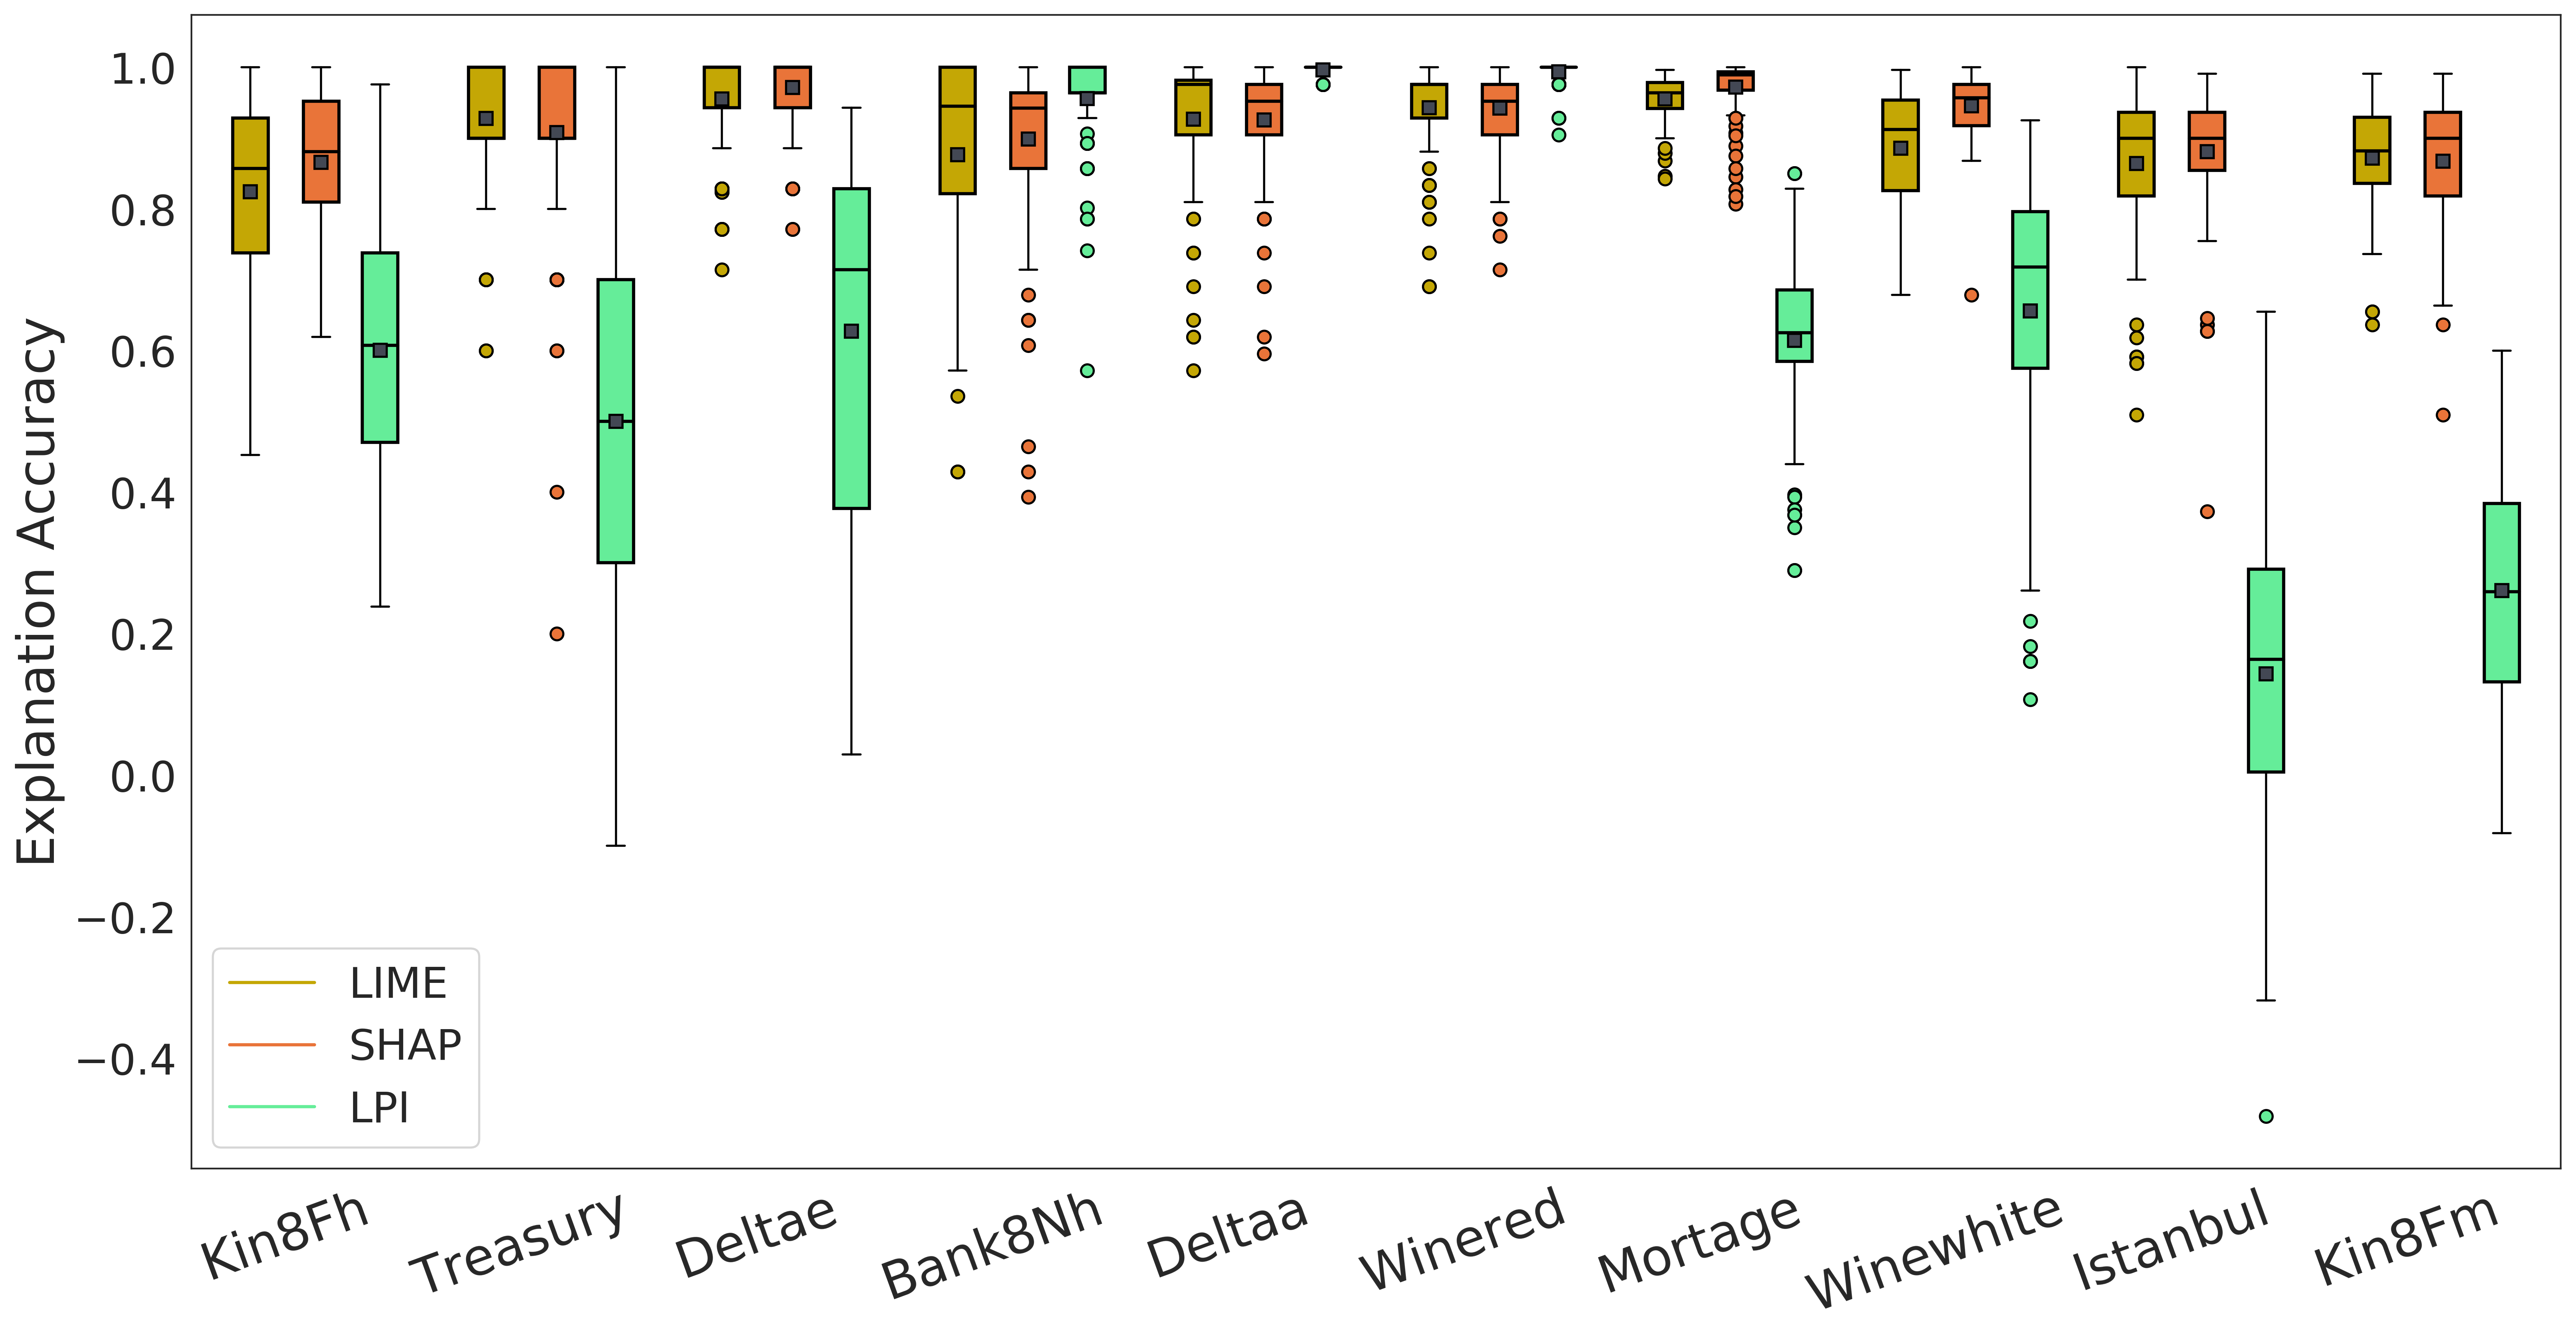

In [239]:
exp_colors = ['#C4A705', '#E97439', '#65ED99']
fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=400)
#ax = ax.ravel()

filter_datasets = {'lr': large_std_lr}

preproc = 'standard'
flierprops = {'lime': dict(marker='o', markeredgecolor='#D7191C'),
              'shap': dict(marker='o', markeredgecolor='#2C7BB6'),
              'permute': dict(marker='o', markeredgecolor='#008000')}

i = 0
rank_dfs = pd.DataFrame()
measure_name = 'spearman_abs'
boxprops = dict(linestyle='-', linewidth=1.5)

model_name = 'lr'
lime_exp_values = get_exp_filter(preproc, model_name, 'lime', measure_name, filter_datasets[model_name])
bp_lime = ax.boxplot(lime_exp_values, positions=np.array(np.arange(lime_exp_values.shape[0]))*2.0-0.3, 
                     widths=0.3, boxprops=boxprops, showfliers=True, flierprops=flierprops['lime'], 
                        patch_artist=True, showmeans=True, 
                        meanprops={'marker':'s', "markerfacecolor":'#434854', "markeredgecolor":"black"})
shap_exp_values = get_exp_filter(preproc, model_name, 'shap', measure_name, filter_datasets[model_name])
bp_shap = ax.boxplot(shap_exp_values, positions=np.array(np.arange(shap_exp_values.shape[0]))*2.0+0.3, 
                     widths=0.3, boxprops=boxprops, showfliers=True, flierprops=flierprops['shap'], 
                        patch_artist=True, showmeans=True, meanprops={'marker':'s', "markerfacecolor":'#434854',
                                                                      "markeredgecolor":"black"})

lpi_exp_values = get_exp_filter(preproc, model_name, 'lpi', measure_name, filter_datasets[model_name])
bp_pi = ax.boxplot(lpi_exp_values, positions=np.array(np.arange(lpi_exp_values.shape[0]))*2.0+0.8, 
                   widths=0.3, boxprops=boxprops, showfliers=True, flierprops=flierprops['permute'], 
                      patch_artist=True, showmeans=True, 
                      meanprops={'marker':'s', "markerfacecolor":'#434854', "markeredgecolor":"black"})

set_box_color(bp_lime,  exp_colors[0])
set_box_color(bp_shap, exp_colors[1])
set_box_color(bp_pi, exp_colors[2])

ax.plot([], c=exp_colors[0], label='LIME')
ax.plot([], c=exp_colors[1], label='SHAP')
ax.plot([], c=exp_colors[2], label='LPI')

ticks = filter_datasets[model_name]
ax.set_xticks(np.arange(0, len(ticks) * 2, 2))
ax.set_xticklabels(ticks, rotation=20, fontsize=24)
ax.set_ylabel('Explanation Accuracy', fontsize=24)
ax.yaxis.set_tick_params(labelsize=20)

ax.legend(prop={'size': 20})    
i+=1

plt.savefig("boxplot_linear_regression.eps", bbox_inches='tight')
plt.show()

In [ ]:
robustness = pickle.load( open( "{}/robustness_measure_regression_v17.p".format(BASE_PATH), "rb" ) )

In [ ]:
def process_ax(ax, label_size=14):
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(width = 2.5, color = '0.2')

    ax.set_xlabel(ax.get_xlabel(), fontsize = label_size, weight = 'bold', color = '0.2')
    ax.set_ylabel(ax.get_ylabel(), fontsize = label_size, weight = 'bold', color = '0.2')

    return ax

cutoffs = np.linspace(0.05, 0.45, 10)
r_types = ['deletion', 'insertion']
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
d_name = 'heating'
m_name = 'lr'
exp_colors = ['#5F8BE9', '#C4A705', '#E97439', '#65ED99']
for i in range(len(r_types)):
    for j in range(len(exp_models)):
        _temp_res = np.array(robustness[m_name][exp_models[j]][d_name][r_types[i]])
        _avg_res = np.mean(_temp_res, axis = 0)
        ax[i].plot(cutoffs, _avg_res, label=exp_models[j], color=exp_colors[j], linewidth=2)
        
        if r_types[i] == 'deletion':
            ax[i].set_xlabel('% Important Features', size=8)
        else: 
            ax[i].set_xlabel('% Unimportant Features', size=10)
        ax[i].set_ylabel(r'$\Delta$  Score', size=10)
        ax[i].tick_params(axis='both', which='major', labelsize=12)
        ax[i] = process_ax(ax[i])
ax[1].legend()
plt.savefig('./robust_{}_{}.eps'.format(d_name, m_name))
plt.show()

In [ ]:
cutoffs = np.linspace(0.05, 0.45, 10)
#robust_type = 'insertion'

def get_auc(model_name, robust_type):
    auc = {}    
    for i in range(len(datasets)):
        auc[datasets[i]] = {}
        temp_res = []
        data_name = datasets[i]

        for j in range(len(exp_models)):   
            auc[datasets[i]][exp_models[j]]  = {}
            res_ins = robustness[model_name][exp_models[j]][datasets[i]][robust_type]
            temp = np.array(res_ins).mean(axis=1)
            auc_ = 0
            for k in range(1, len(cutoffs) - 1):
                x = cutoffs[k] - cutoffs[k - 1]
                y = temp[k] + temp[k-1]
                auc_ += y / ( 2 * x)
            auc[datasets[i]][exp_models[j]] = auc_ 
            
    return auc

In [ ]:
base_rri = pd.DataFrame(get_auc('lr', 'insertion'))
base_rri = base_rri.append(pd.DataFrame(get_auc('lr', 'deletion'))).T
base_rri.columns = ['LIME', 'SHAP', 'LPI', 'LIME', 'SHAP', 'LPI']
base_rri.index = dataset_names

In [ ]:
base_rri = base_rri.sort_index()

In [ ]:
base_rri.loc['Average'] = base_rri.mean(axis=0)
base_rri.loc['Standard Deviation'] = base_rri.std(axis=0)

In [ ]:
base_rri.iloc[:,0:3].style.highlight_min(axis=1)

In [ ]:
base_rri.iloc[:,3:6].style.highlight_max(axis=1)

In [ ]:
print(tabulate(base_rri.round(2), tablefmt="latex_raw"))

In [ ]:
base_rri.iloc[:,0:3].style.highlight_min(axis=1)